# Notebook for visualization (Price Forecasting Model)

In [1]:
import numpy as np
import pandas as pd


from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import StandardScaler


df_energy = pd.read_csv("C:/Users/pacos/Desktop/AWS_Group_Project/Complete Datasets/energy_dataset.csv")

df_weather = pd.read_csv("C:/Users/pacos/Desktop/AWS_Group_Project/Complete Datasets/weather_features.csv")

df = pd.merge(df_energy, df_weather, left_on='time', right_on='dt_iso', how='right')

df.drop(columns=['dt_iso', 'generation fossil coal-derived gas',
                 'generation fossil oil shale', 'generation fossil peat', 
                 'generation geothermal', 'generation marine', 'generation wind offshore', 
                 'generation hydro pumped storage aggregated',
                 'forecast wind offshore eday ahead', 'weather_description', 
                 'weather_id', 'weather_icon', 'forecast solar day ahead', 
                 'forecast wind onshore day ahead', 'total load forecast'], axis=1, inplace=True)

# Split the 'time' column into 'date' and 'hour' columns
df[['date', 'hour']] = df['time'].str.split(' ', expand=True)

# Split the 'hour' column further to exclude the timezone information
df['hour'] = df['hour'].str.split('+', expand=True)[0]

# Now we can drop the 'time' column, since we won't need it anymore to merge the tables
df.drop('time', axis=1, inplace=True)

# Create X matrix and y array
y = df['price actual']
X = df.drop('price actual', axis = 1)

In [2]:
# Create one-hot encoded columns for city_name
X = pd.get_dummies(X, columns=['city_name'])
X = pd.get_dummies(X, columns=['weather_main'])

In [3]:

### Adjust the date column
X['date'] = pd.to_datetime(X['date'])
# Double-validate the correct format of the date
X['date'] = X['date'].dt.strftime('%Y-%m-%d')

# Extract the year, month, and day components from the 'date' column
X['year'] = X['date'].apply(lambda x: int(x[:4]))
X['month'] = X['date'].apply(lambda x: int(x[5:7]))
X['day'] = X['date'].apply(lambda x: int(x[8:10]))
# Drop original column
X.drop('date', axis=1, inplace=True)


### Adjust the time column
from datetime import datetime
X['hour'] = X['hour'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())
# We need to use apply since it's a Series
X['hour'] = X['hour'].apply(lambda x: x.hour)

In [4]:
df = pd.concat([y, X], axis=1)

In [5]:
df_predictions = pd.read_csv("C:/Users/pacos/Desktop/AWS_Group_Project/predictions_10000_price.csv")

In [6]:
df_predictions

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,weather_main_fog,weather_main_haze,weather_main_mist,weather_main_rain,weather_main_smoke,weather_main_snow,weather_main_squall,weather_main_thunderstorm,total load actual,predicted_value
0,111,327,4721,226,492,3016,278,8459,6307,3,...,0,0,0,0,0,0,0,0,30691,97.962639
1,242,288,2405,5059,243,3497,896,8473,5648,49,...,0,0,0,0,0,1,0,0,22192,100.667877
2,579,673,8823,2277,4,2259,431,7597,3986,85,...,0,0,0,0,0,0,0,0,21984,104.164330
3,497,391,10958,3659,28,118,528,6147,6857,86,...,1,0,0,0,0,0,0,0,32445,98.879997
4,325,675,11353,3465,434,1189,889,6351,2551,98,...,0,0,0,0,0,0,0,0,36500,102.362297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,244,291,6526,839,43,1496,52,2812,6586,96,...,0,1,0,0,0,0,0,0,27190,97.308807
9996,334,587,9514,7994,335,2979,1047,4074,6500,37,...,0,0,0,0,0,0,0,0,37956,99.207344
9997,224,635,1080,1429,459,1719,201,7778,6468,37,...,0,0,0,0,0,0,0,0,35174,97.919464
9998,148,878,8025,2171,304,1977,989,5708,5450,49,...,0,0,0,0,0,0,0,0,34256,97.528374


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# define the columns to group by and aggregate
group_cols = ['month', 'day']
# target variable
agg_col = 'price actual'

# group the training data by the specified columns and aggregate the target variable
train_agg = df.groupby(group_cols).agg({agg_col: 'mean'}).reset_index()

# get the row of the prediction dataframe you want to plot
pred_row = df_predictions.loc[20]

# extract the values for the group columns from the prediction row
pred_group = tuple(pred_row[group_cols].values.astype(int))



In [8]:
train_agg

,month,day,price actual
0,1,1,46.195342
1,1,2,56.790477
2,1,3,54.059414
3,1,4,55.018606
4,1,5,60.334901
...,...,...,...
361,12,27,58.279732
362,12,28,60.172112
363,12,29,60.427531
364,12,30,58.011872


In [9]:
pred_group

(11, 4)

In [10]:
#tuple(pred_group)

In [11]:
# find the matching group in the training data and extract the aggregated value
train_agg_val = train_agg.loc[train_agg[group_cols].apply(lambda x: tuple(x.values) == pred_group, axis=1), agg_col].values[0]

In [12]:
train_agg_val

63.329524752475244

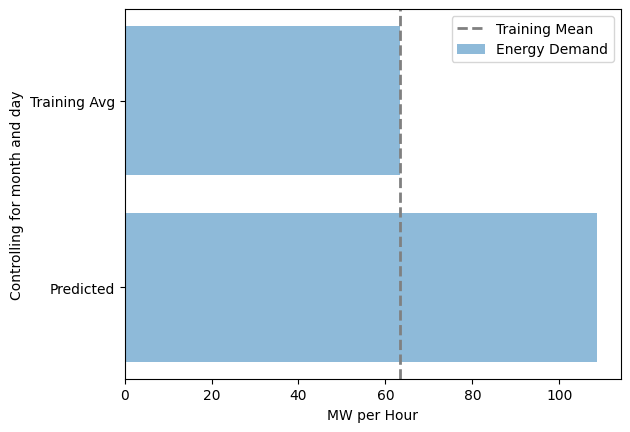

In [13]:
# plot the predicted value and the training data average
plt.barh(['Predicted', 'Training Avg'], [pred_row['predicted_value'], train_agg_val], alpha=0.5, label='Energy Demand')
plt.axvline(x=df.loc[df[group_cols].apply(lambda x: tuple(x.values) == pred_group, axis=1), agg_col].values.mean(), color='gray', linestyle='dashed', linewidth=2, label='Training Mean')
plt.xlabel('MW per Hour')
plt.ylabel('Controlling for month and day')
plt.legend(loc='upper right')
plt.show()


# Graph 2: Grouped by City

In [14]:
# create a list of the dummy columns
dummy_cols = ['city_name_ Barcelona', 'city_name_Bilbao', 'city_name_Madrid', 'city_name_Seville', 'city_name_Valencia']

# create a new column called 'city' by finding the column with the highest value for each row
df['city'] = df[dummy_cols].idxmax(axis=1).str.replace('city_name_', '')


In [15]:
df['city'].value_counts()

Madrid        36267
Bilbao        35951
Seville       35557
 Barcelona    35476
Valencia      35145
Name: city, dtype: int64

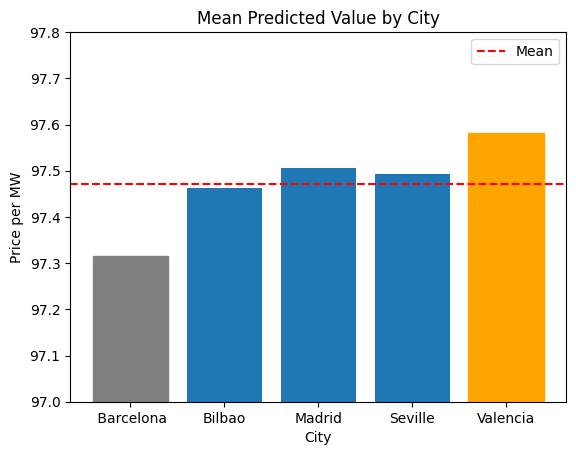

In [16]:
# create a new column called 'city' by finding the column with the highest value for each row
df_predictions['city'] = df_predictions[dummy_cols].idxmax(axis=1).str.replace('city_name_', '')

# group by city and compute the mean of predicted_value
grouped = df_predictions.groupby('city')['predicted_value'].mean()

# plot the bar chart
fig, ax = plt.subplots()
ax.bar(grouped.index, grouped.values)
ax.set_xlabel('City')
ax.set_ylabel('Price per MW')
ax.set_title('Mean Predicted Value by City')

# set y-axis range
ax.set_ylim([97, 97.8])

# add mean line
mean_val = grouped.mean()
ax.axhline(y=mean_val, color='red', linestyle='--', label='Mean')

# colour Madrid column
rects = ax.patches
for i in range(len(rects)):
    if grouped.index[i] == 'Valencia':
        rects[i].set_color('orange')
    if grouped.index[i] == ' Barcelona':
        rects[i].set_color('gray')
    
    

plt.legend()
plt.show()


In [17]:
grouped

city
 Barcelona    97.315744
Bilbao        97.462386
Madrid        97.506478
Seville       97.493508
Valencia      97.581868
Name: predicted_value, dtype: float64

## On original dataset

In [18]:
df_test = pd.merge(df_energy, df_weather, left_on='time', right_on='dt_iso', how='right')


In [19]:
df_test['price actual']

0         65.41
1         64.92
2         64.48
3         59.32
4         56.04
          ...  
178391    77.02
178392    76.16
178393    74.30
178394    69.89
178395    69.88
Name: price actual, Length: 178396, dtype: float64

In [20]:
df_test.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wi

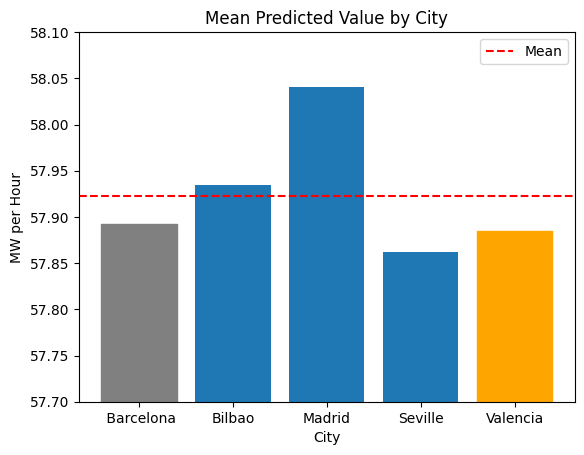

In [21]:
# create a new column called 'city' by finding the column with the highest value for each row


# group by city and compute the mean of predicted_value
grouped = df_test.groupby('city_name')['price actual'].mean()

# plot the bar chart
fig, ax = plt.subplots()
ax.bar(grouped.index, grouped.values)
ax.set_xlabel('City')
ax.set_ylabel('MW per Hour')
ax.set_title('Mean Predicted Value by City')

# set y-axis range
ax.set_ylim([57.7, 58.1])

# add mean line
mean_val = grouped.mean()
ax.axhline(y=mean_val, color='red', linestyle='--', label='Mean')

# colour Madrid column
rects = ax.patches
for i in range(len(rects)):
    if grouped.index[i] == 'Valencia':
        rects[i].set_color('orange')
    if grouped.index[i] == ' Barcelona':
        rects[i].set_color('gray')
    
    

plt.legend()
plt.show()


In [22]:
grouped

city_name
 Barcelona    57.892862
Bilbao        57.934837
Madrid        58.040317
Seville       57.861901
Valencia      57.884460
Name: price actual, dtype: float64

# Graph 3: Grouped by Weather

In [23]:
#df_predictions.columns

In [24]:
# create a list of the dummy columns
dummy_cols_weather = ['weather_main_clear', 'weather_main_clouds', 'weather_main_drizzle', 
              'weather_main_dust', 'weather_main_fog', 'weather_main_haze',
             'weather_main_mist', 'weather_main_rain', 'weather_main_smoke', 'weather_main_snow',
             'weather_main_squall', 'weather_main_thunderstorm' ]

# create a new column called 'city' by finding the column with the highest value for each row
df['weather'] = df[dummy_cols_weather].idxmax(axis=1).str.replace('weather_main_', '')
df_predictions['weather'] = df_predictions[dummy_cols_weather].idxmax(axis=1).str.replace('weather_main_', '')



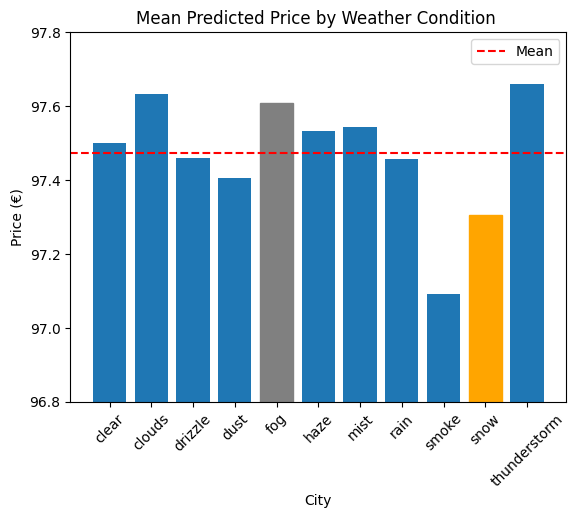

In [25]:
# group by city and compute the mean of predicted_value
grouped = df_predictions.groupby('weather')['predicted_value'].mean()

# plot the bar chart
fig, ax = plt.subplots()
ax.bar(grouped.index, grouped.values)
ax.set_xlabel('City')
ax.set_ylabel('Price (€)')
ax.set_title('Mean Predicted Price by Weather Condition ')

# set y-axis range
ax.set_ylim([96.8, 97.8])

# add mean line
mean_val = grouped.mean()
ax.axhline(y=mean_val, color='red', linestyle='--', label='Mean')

# colour Madrid column
rects = ax.patches
for i in range(len(rects)):
    if grouped.index[i] == 'fog':
        rects[i].set_color('gray')
    if grouped.index[i] == 'snow':
        rects[i].set_color('orange')
    
# rotate xticks
plt.xticks(rotation=45)   

plt.legend()
plt.show()


In [26]:
grouped

weather
clear           97.499924
clouds          97.632958
drizzle         97.457988
dust            97.404477
fog             97.606696
haze            97.532252
mist            97.543254
rain            97.456111
smoke           97.090233
snow            97.305329
thunderstorm    97.658573
Name: predicted_value, dtype: float64

## On Original Dataset

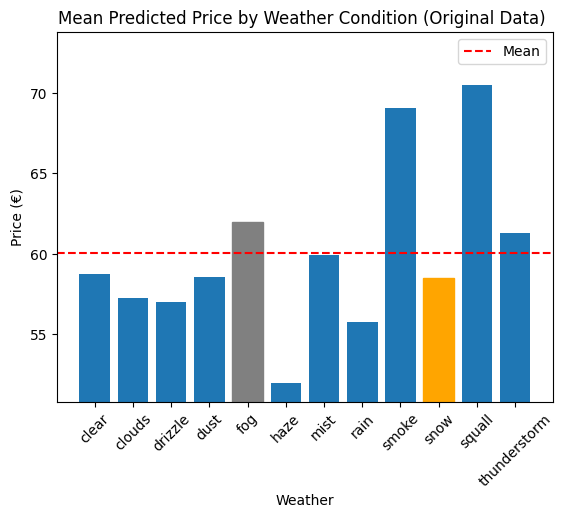

In [27]:
# group by city and compute the mean of predicted_value
grouped = df_test.groupby('weather_main')['price actual'].mean()

# plot the bar chart
fig, ax = plt.subplots()
ax.bar(grouped.index, grouped.values)
ax.set_xlabel('Weather')
ax.set_ylabel('Price (€)')
ax.set_title('Mean Predicted Price by Weather Condition (Original Data) ')

# set y-axis range
ax.set_ylim([50.8, 73.8])

# add mean line
mean_val = grouped.mean()
ax.axhline(y=mean_val, color='red', linestyle='--', label='Mean')

# colour Madrid column
rects = ax.patches
for i in range(len(rects)):
    if grouped.index[i] == 'fog':
        rects[i].set_color('gray')
    if grouped.index[i] == 'snow':
        rects[i].set_color('orange')
    
# rotate xticks
plt.xticks(rotation=45)   

plt.legend()
plt.show()


# Graph 4: Grouped by Month

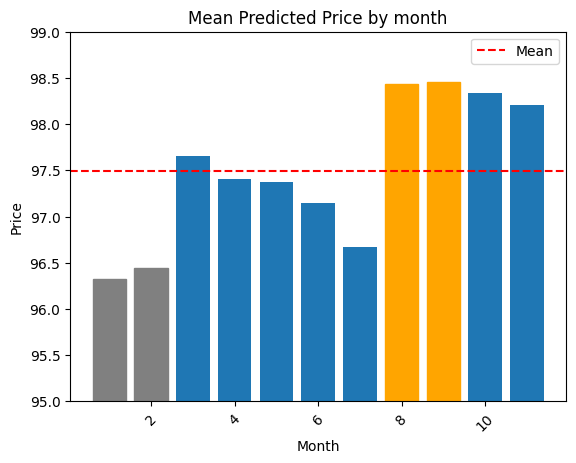

In [28]:
# group by city and compute the mean of predicted_value
grouped = df_predictions.groupby('month')['predicted_value'].mean()

# plot the bar chart
fig, ax = plt.subplots()
ax.bar(grouped.index, grouped.values)
ax.set_xlabel('Month')
ax.set_ylabel('Price')
ax.set_title('Mean Predicted Price by month')

# set y-axis range
ax.set_ylim([95, 99])

# add mean line
mean_val = grouped.mean()
ax.axhline(y=mean_val, color='red', linestyle='--', label='Mean')

# colour Madrid column
rects = ax.patches
for i in range(len(rects)):
    if grouped.index[i] == 8 or grouped.index[i] == 9:
        rects[i].set_color('orange')
    if grouped.index[i] < 3:
        rects[i].set_color('gray')
    
# rotate xticks
plt.xticks(rotation=45)   

plt.legend()
plt.show()

In [29]:
grouped

month
1     96.325402
2     96.439614
3     97.656409
4     97.402661
5     97.371604
6     97.150559
7     96.668123
8     98.437908
9     98.452302
10    98.333585
11    98.202401
Name: predicted_value, dtype: float64

# Hexbins

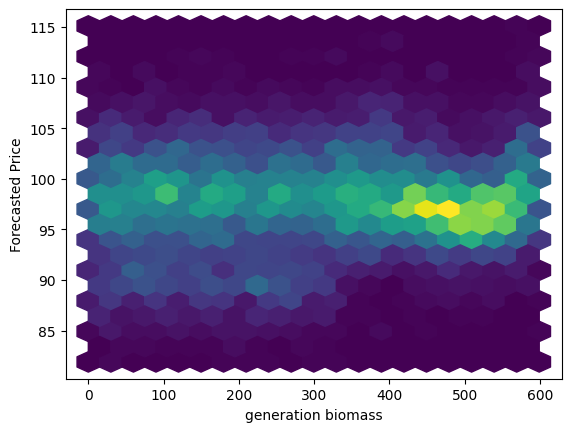

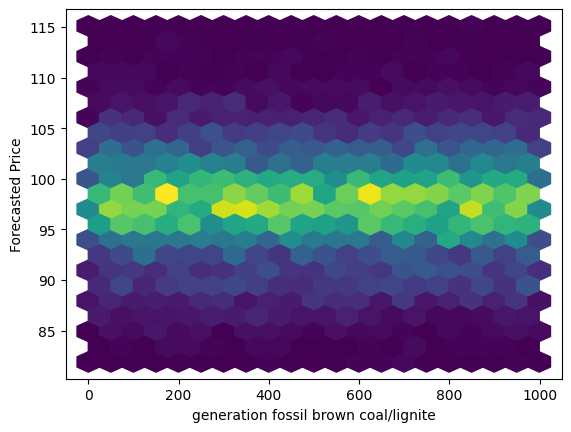

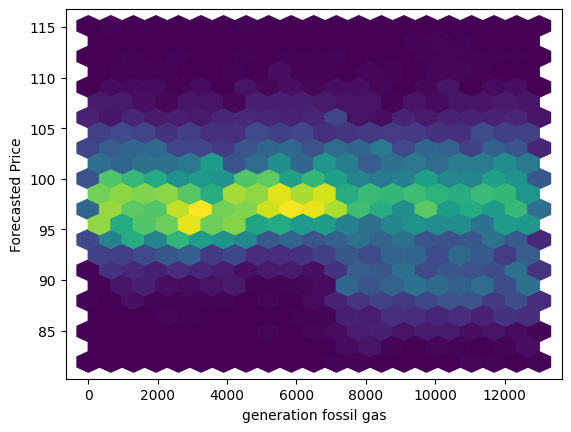

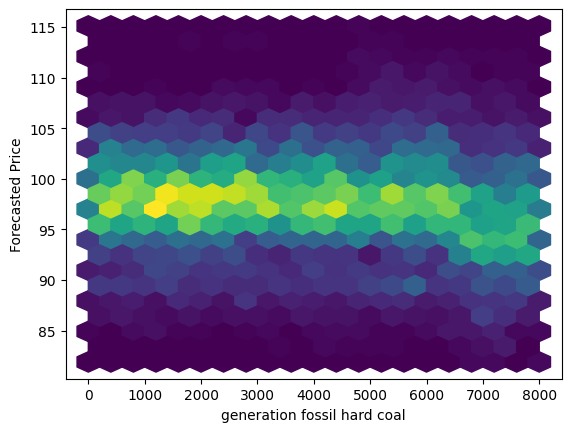

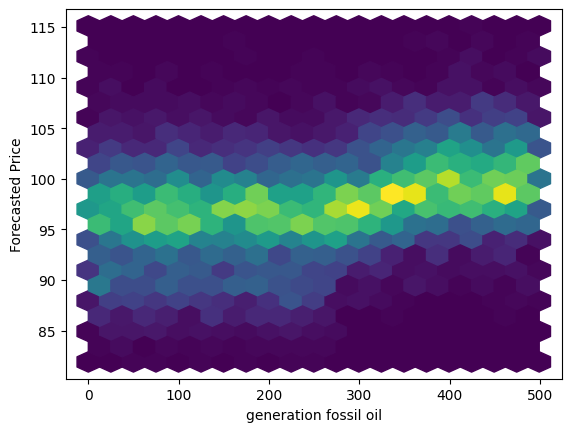

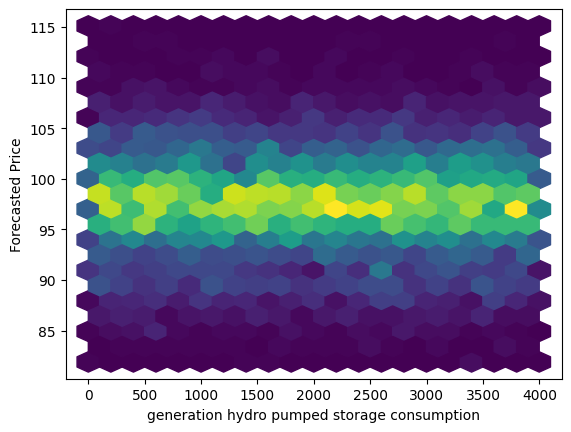

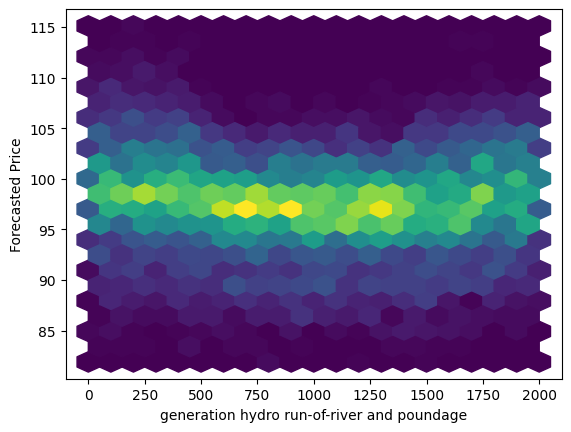

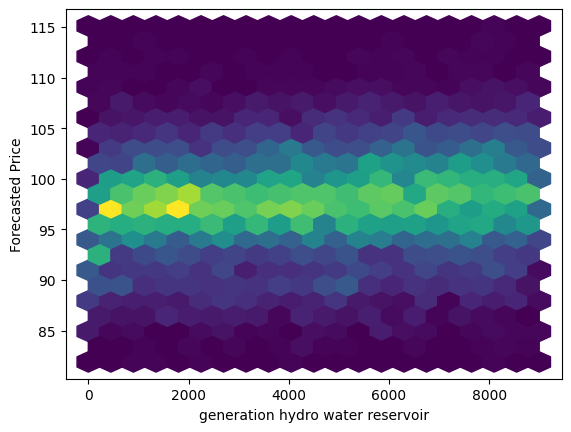

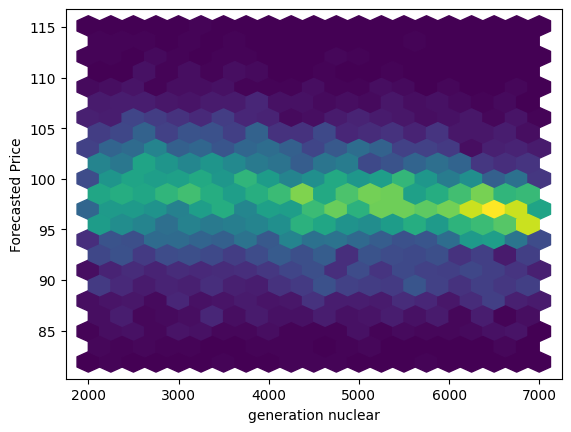

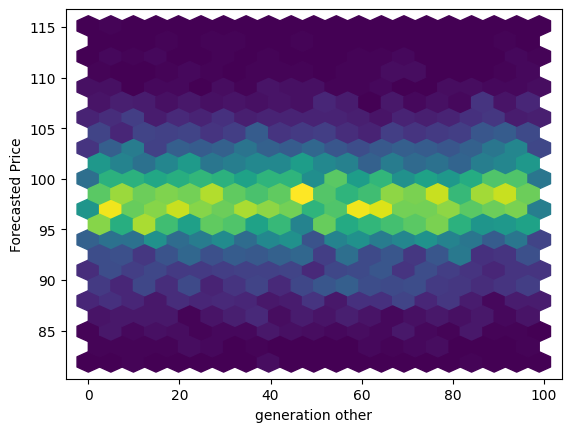

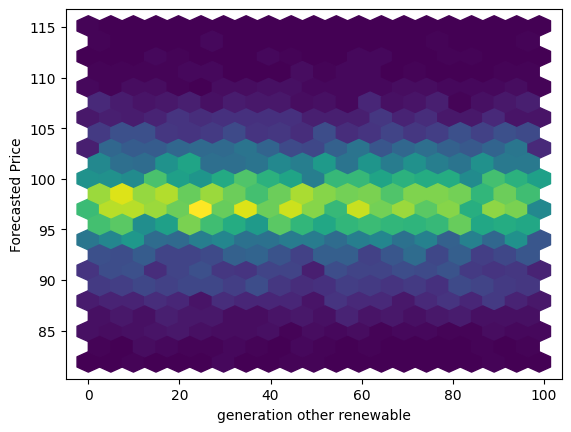

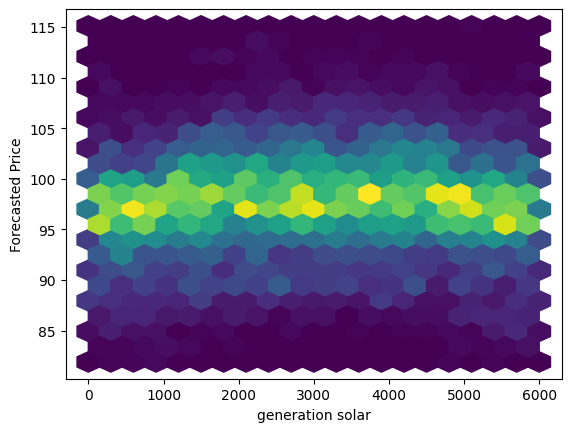

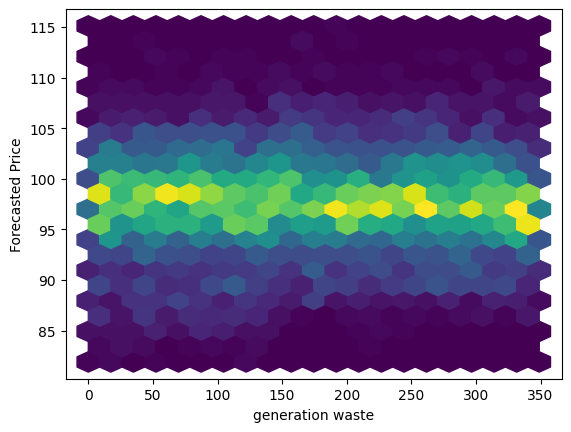

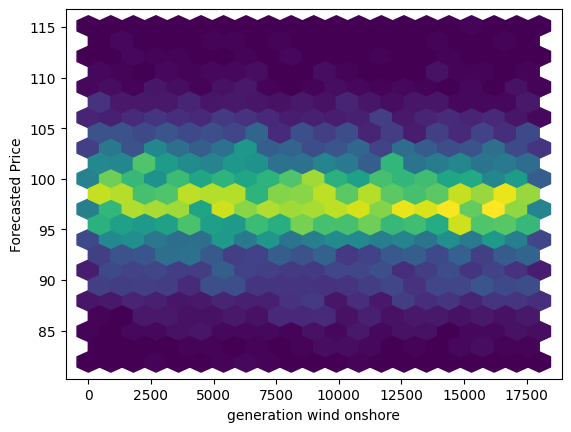

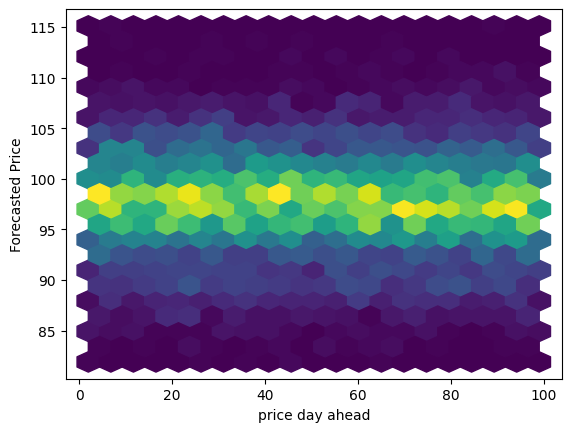

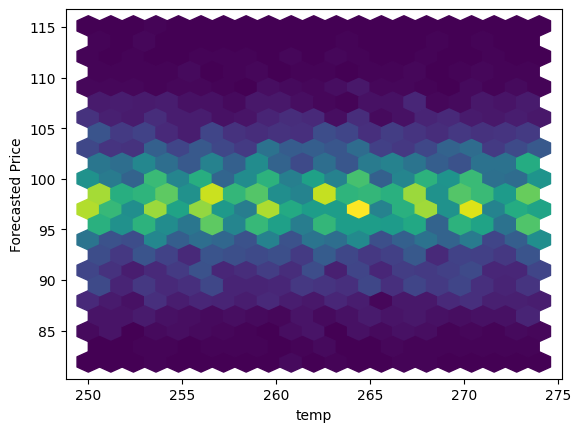

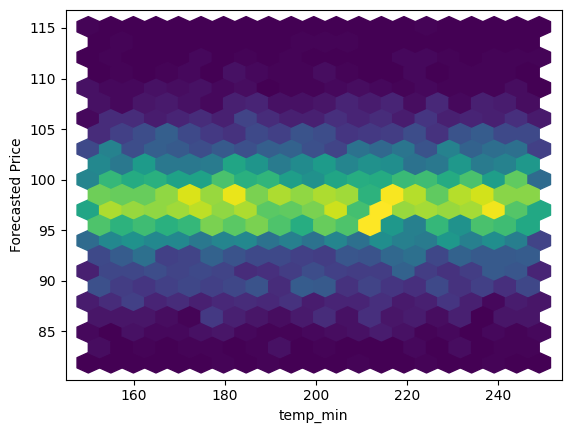

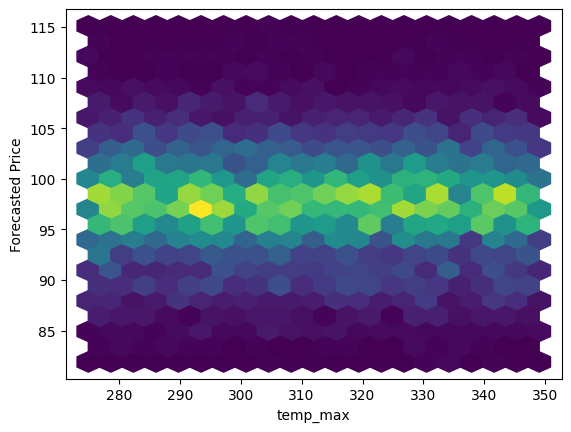

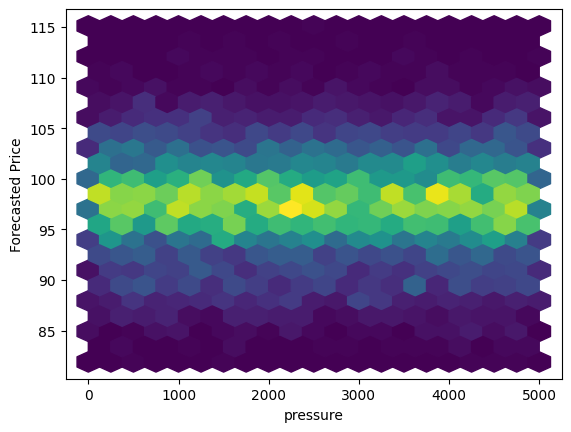

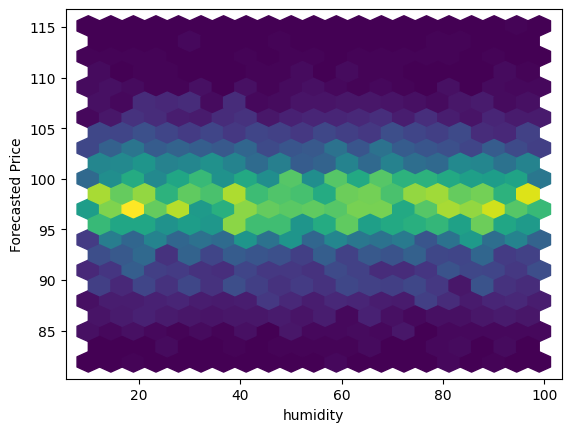

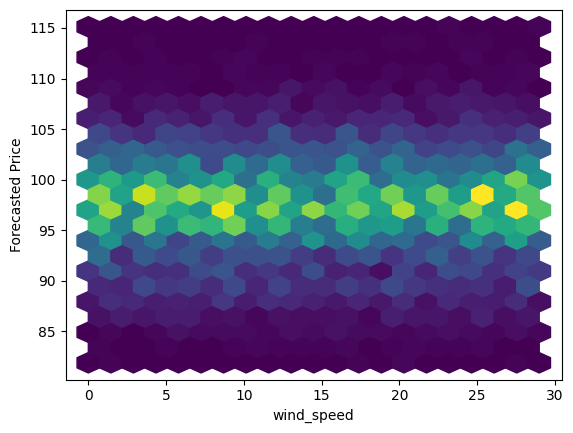

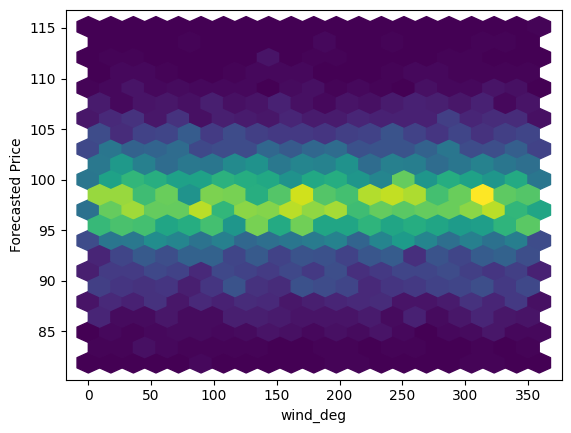

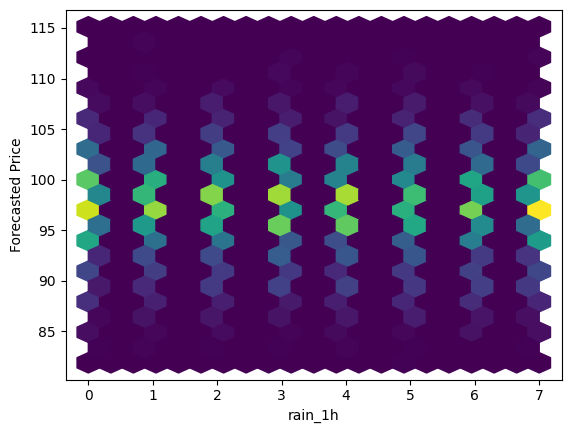

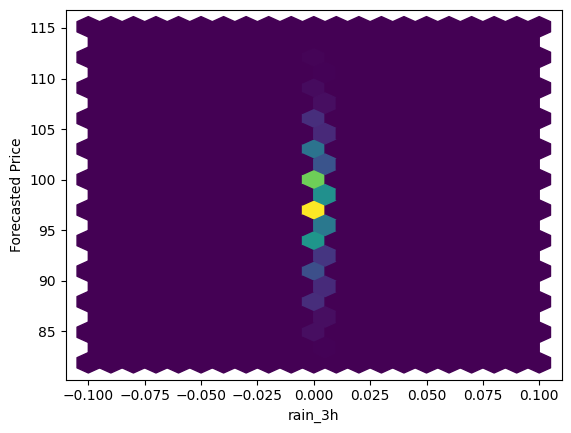

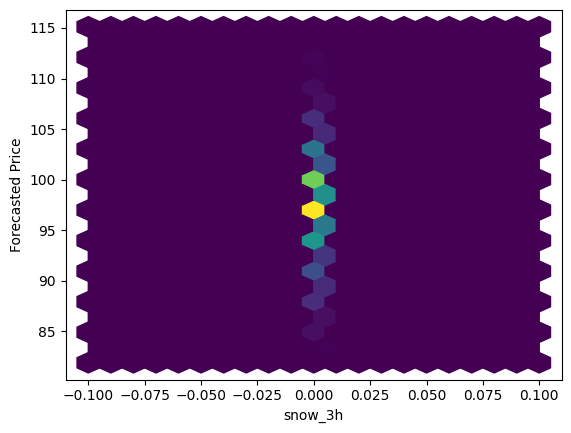

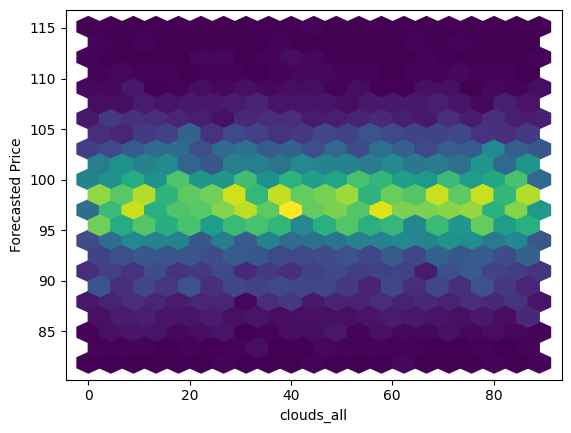

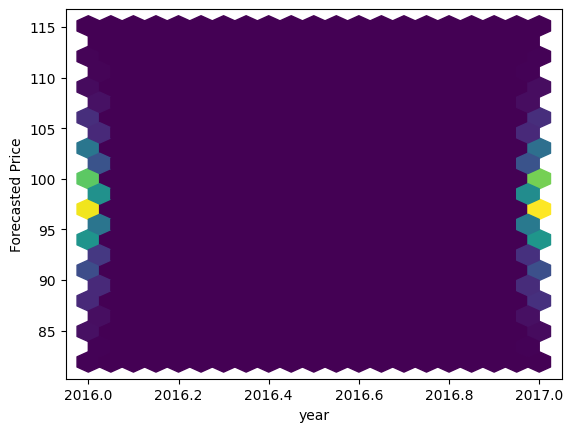

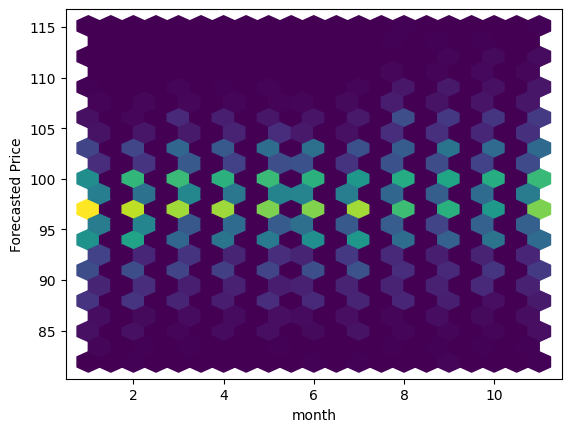

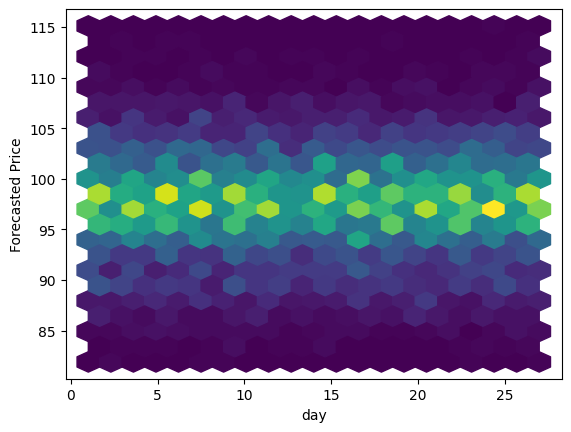

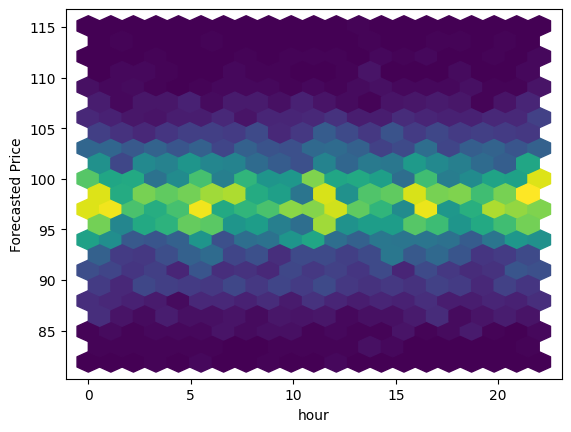

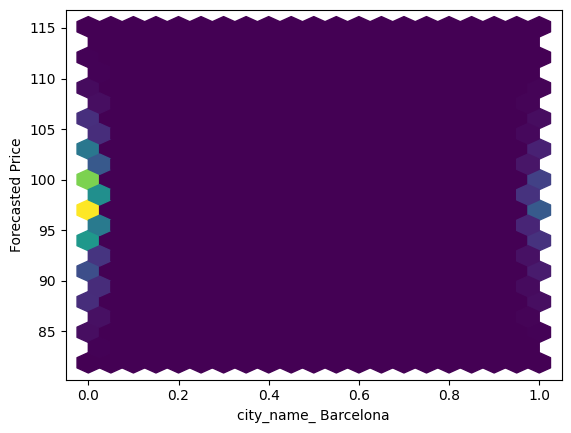

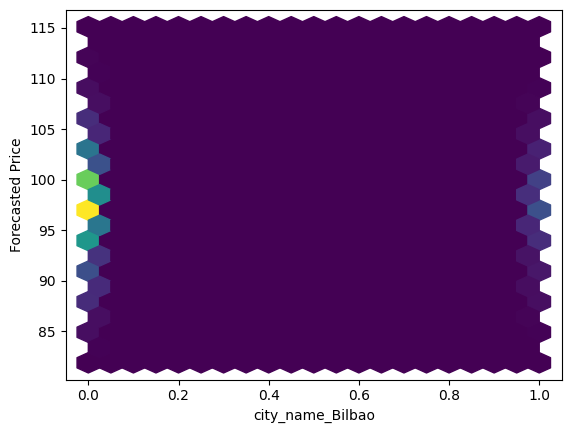

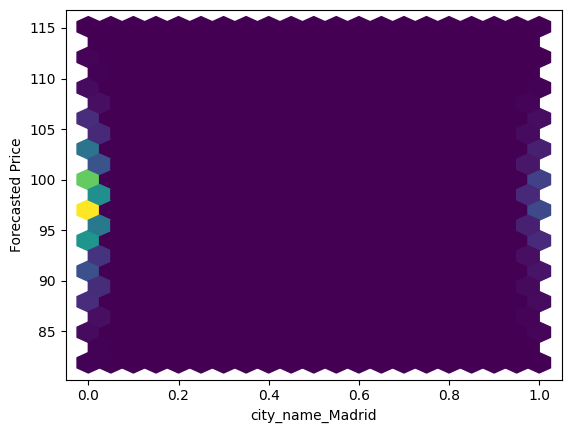

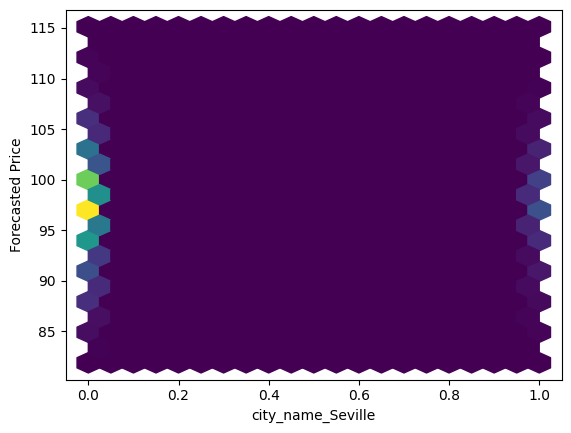

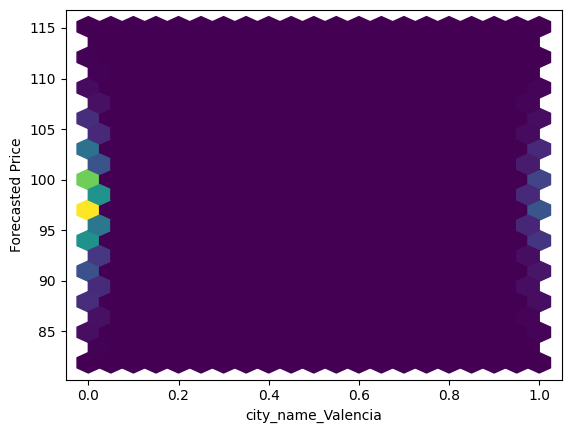

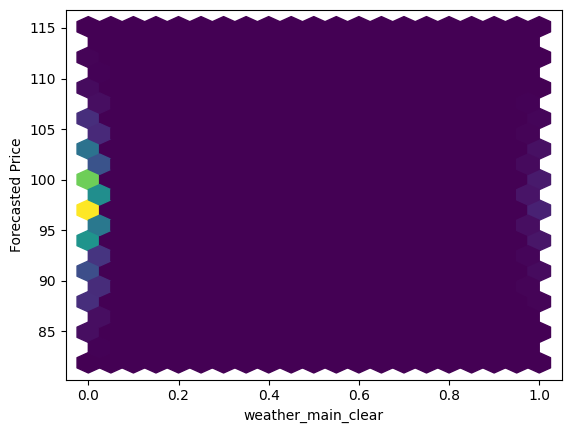

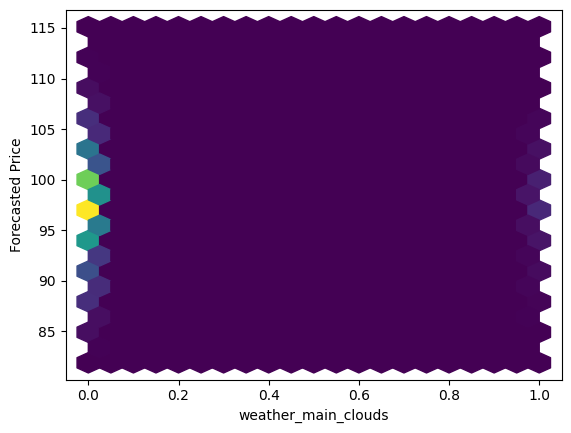

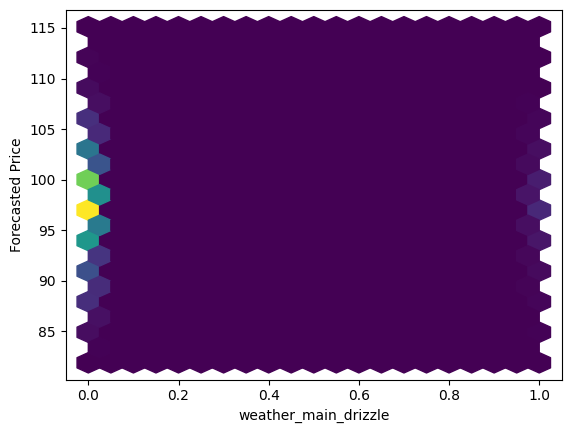

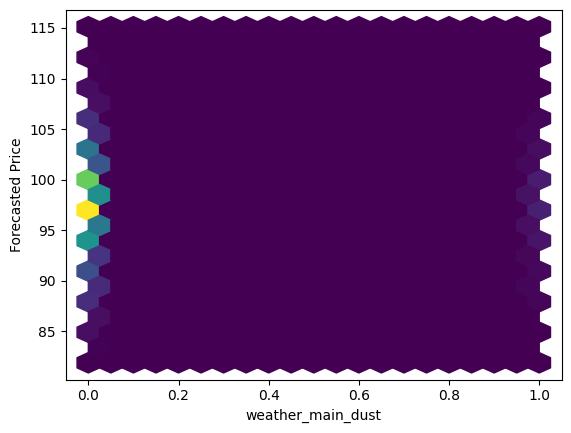

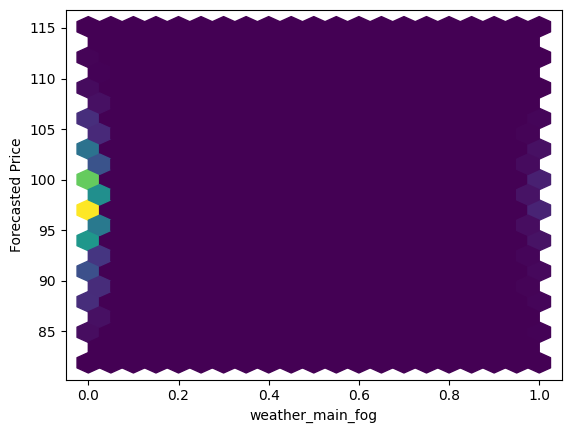

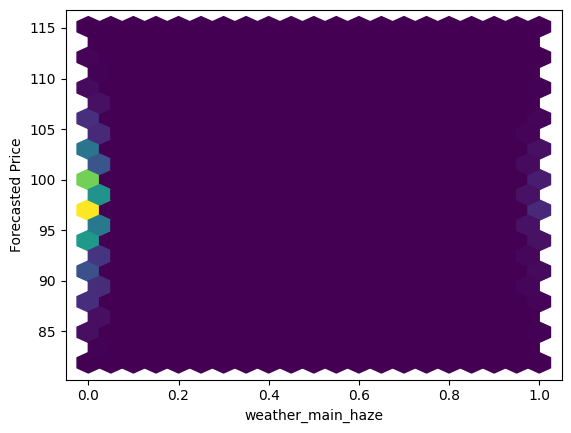

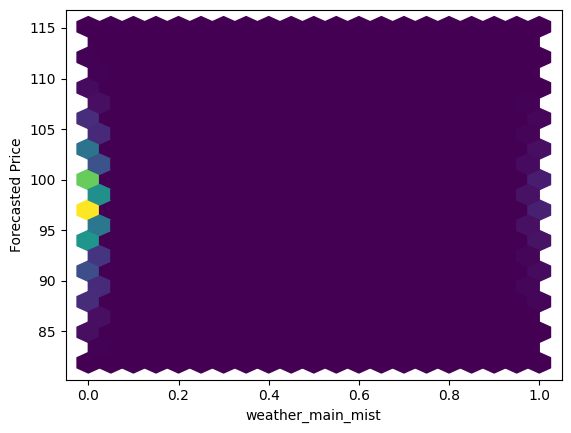

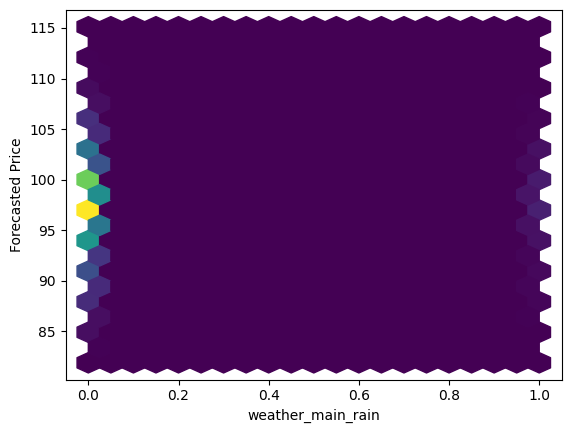

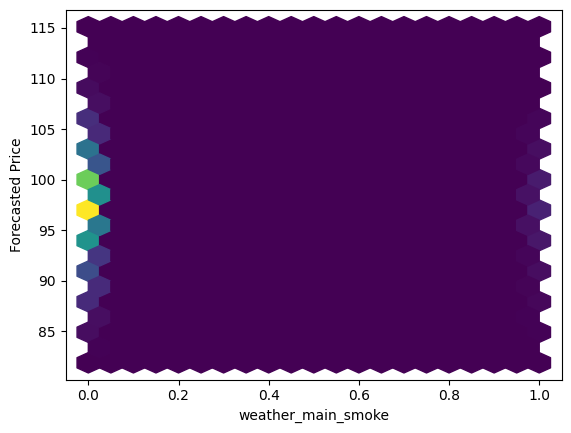

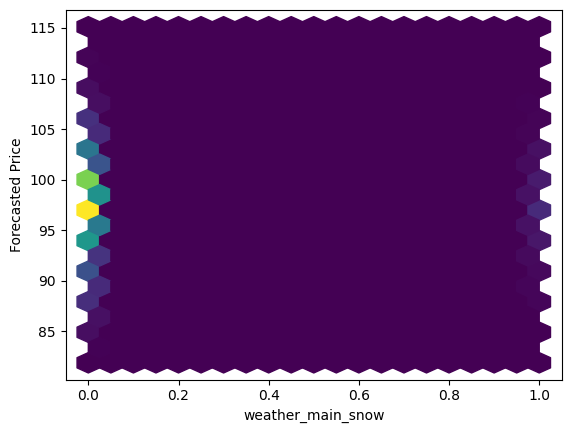

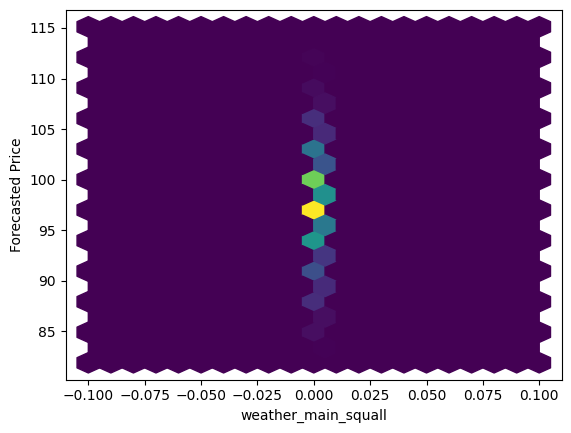

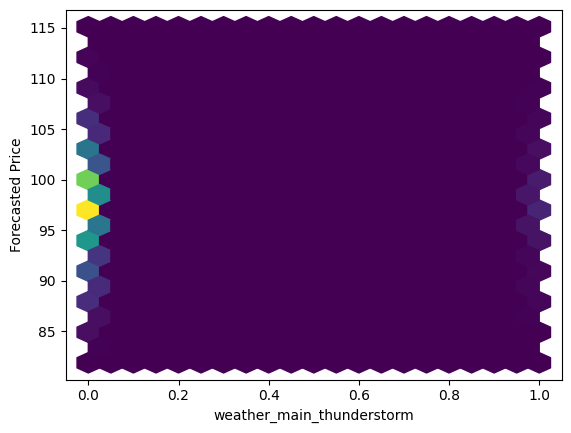

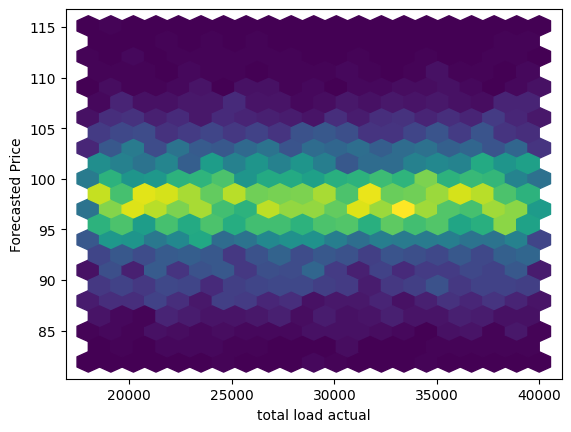

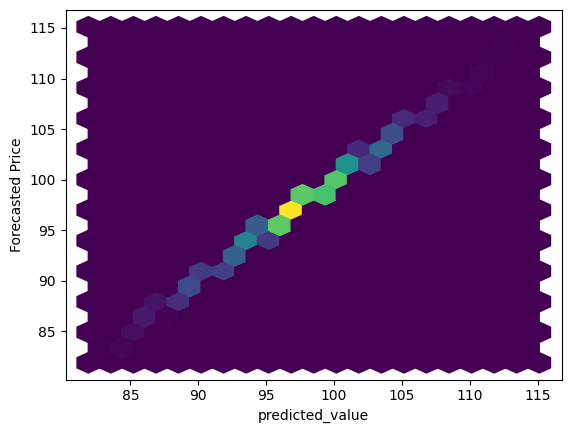

In [30]:
import matplotlib.pyplot as plt


num_cols = df_predictions.select_dtypes(include=['float', 'int']).columns

for col in num_cols:
    plt.hexbin(df_predictions[col], df_predictions['predicted_value'], gridsize=20)
    plt.xlabel(col)
    plt.ylabel('Forecasted Price')
    plt.show()